In [175]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas._libs.tslibs import dtypes, timestamps
import subprocess
from functools import reduce

In [176]:
def printRow(row):
    print("TIME:", row['system_time'])
    print(row['action'])
    print("==============")

system = "slurm"
if system == "aurora01":
    stat_dir = "/home/gsd/andrelucena/statistics"
elif system == "slurm":
    stat_dir = "/projects/a97485/statistics"

model = "resnet50"
n_nodes = "4"
n_epochs = "2"
batch_size = "64"
save_every = "1"
log = "true"

stat_test = "eBPFs_subset"
if system == "aurora01":
    test_name = model + "_" + n_epochs + "_" + batch_size + "_" + save_every + "_" + log
elif system == "slurm":
    test_name = model + "_" + n_nodes + "_" + n_epochs + "_" + batch_size + "_" + save_every + "_" + log

full_test_path = stat_dir + "/" + stat_test + "/" + test_name
if system == "slurm":
    full_test_path += "/aurora03"

p = subprocess.Popen(["scp", f"{system}:{full_test_path}/out.out", "./file"])
sts = os.waitpid(p.pid, 0)

df = pd.read_csv("./file", skiprows=[0,1,2,3,4], names=['system_time'], index_col=False, delimiter='/')

os.remove("./file")

df = df['system_time'].str.extract(r'[\t]*(?P<system_time>[^\t:]*:[^:]*:[^:]*):(?P<action>.*)')
df = df.dropna()
print(df.head())

                          system_time  \
0          2024-11-05 01:27:19.453645   
1          2024-11-05 01:27:19.454282   
3          2024-11-05 01:27:20.064135   
4          2024-11-05 01:27:20.064876   
5          2024-11-05 01:27:20.065609   

                                     action  
0                            Training begin  
1                          Training epoch 1  
3                Start Training Iteration 0  
4   Moving data to the same device as model  
5                          Computing output  


In [177]:
df['system_time'] = pd.to_datetime(df['system_time'], format='ISO8601')
print(df['system_time'])

0       2024-11-05 01:27:19.453645
1       2024-11-05 01:27:19.454282
3       2024-11-05 01:27:20.064135
4       2024-11-05 01:27:20.064876
5       2024-11-05 01:27:20.065609
                   ...            
17536   2024-11-05 01:44:28.232450
17537   2024-11-05 01:44:28.278464
17538   2024-11-05 01:44:28.279262
17539   2024-11-05 01:44:28.436389
17540   2024-11-05 01:44:28.978124
Name: system_time, Length: 17539, dtype: datetime64[ns]


In [ ]:
df.dtypes

In [178]:
print(df['action'].unique())
df['action'] = df['action'].replace([r'Training epoch.*', r'Trained epoch.*', r'Epoch \d \| Saving.*', r'Epoch \d \| Checkpoint.*', r'Ended.*', r'Start.*'], 
                                    ['Training Epoch', 'Trained Epoch', 'Saving Checkpoint', 'Saved Checkpoint', 'Ended Training Iteration', 'Start Training Iteration'], 
                                    regex=True)
df = df[~df['action'].str.contains('Accuracy')]
df['action'] = df['action'].astype(str)
print(df['action'].value_counts())

[' Training begin' ' Training epoch 1' ' Start Training Iteration 0' ...
 " Accuracy top1: tensor([18.1601], device='cuda:0'); Accuracy top5: tensor([40.8385], device='cuda:0')"
 ' Epoch 2 | Saving checkpoint at checkpoint.pt'
 ' Epoch 2 | Checkpoint saved at checkpoint.pt']
action
Moving data to the same device as model    2504
Start Training Iteration                   2504
Computing Loss                             2504
Computing output                           2504
Ended Training Iteration                   2504
SGD step                                   2504
Compute gradient                           2504
Training Epoch                                2
Saving Checkpoint                             2
Trained Epoch                                 2
Saved Checkpoint                              2
Training begin                                1
Name: count, dtype: int64


In [179]:
def concat(series):
    return reduce(lambda x, y: x + "\n" + y, series)

print(df.head())

df = df.groupby('system_time', as_index=False).agg({'action':concat})

df.head()

for index, row in df.iterrows():
    printRow(row)

                 system_time                                    action
0 2024-11-05 01:27:19.453645                            Training begin
1 2024-11-05 01:27:19.454282                            Training Epoch
3 2024-11-05 01:27:20.064135                  Start Training Iteration
4 2024-11-05 01:27:20.064876   Moving data to the same device as model
5 2024-11-05 01:27:20.065609                          Computing output
TIME: 2024-11-05 01:27:19.453645
 Training begin
TIME: 2024-11-05 01:27:19.454282
 Training Epoch
TIME: 2024-11-05 01:27:20.064135
 Start Training Iteration
TIME: 2024-11-05 01:27:20.064876
 Moving data to the same device as model
TIME: 2024-11-05 01:27:20.065609
 Computing output
TIME: 2024-11-05 01:27:20.969940
 Computing Loss
TIME: 2024-11-05 01:27:21.109557
 Compute gradient
TIME: 2024-11-05 01:27:21.656395
 SGD step
TIME: 2024-11-05 01:27:21.894111
 Ended Training Iteration
TIME: 2024-11-05 01:27:21.894844
 Start Training Iteration
TIME: 2024-11-05 01:27:21.89534

In [180]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17537 entries, 0 to 17536
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   system_time  17537 non-null  datetime64[ns]
 1   action       17537 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 274.1+ KB
None
                 system_time                                    action
0 2024-11-05 01:27:19.453645                            Training begin
1 2024-11-05 01:27:19.454282                            Training Epoch
2 2024-11-05 01:27:20.064135                  Start Training Iteration
3 2024-11-05 01:27:20.064876   Moving data to the same device as model
4 2024-11-05 01:27:20.065609                          Computing output


In [ ]:
def plotAction(df_param: pd.DataFrame, startTime = None, endTime = None):

    dt = df_param
    if not (startTime == None or endTime == None):
        dt.index = pd.DatetimeIndex(df_param['system_time'])
        dt = df_param.between_time(startTime, endTime)

    # plots action with time
    plt.figure()
    plt.plot(dt['system_time'], dt['action'], linestyle='None', markersize = 10.0, marker = ".")
    plt.xlabel('Time')
    plt.ylabel('Action')
    plt.title('Action per time')
    #plt.legend()
    plt.show()

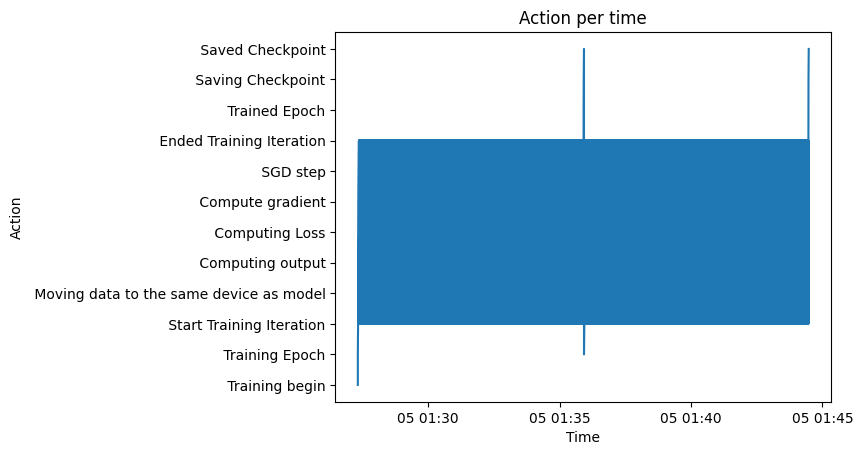

In [181]:
plotAction(df)

In [ ]:
plotAction(df, "1:35:05", "1:35:10")